# Using RISGW

Rotation invariant sliced gromov wasserstein distance might be the ideal metric to train the SE(3) transformer. We explore some of its aspects in the present notebook.

#### On random points

In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
from se3_transformer_pytorch.irr_repr import rot
from src.ri_distances.SGW.risgw import risgw_gpu,train_and_get_RISGW_affine_map
from from src.ri_distances.SGW.sgw_pytorch import sgw_gpu
from src.se3.torch_funcs import (center, get_rotation_matrix,
                                 get_src_scaled_spirals, to_numpy_array)
from src.se3.visualization import viz_point_cloud
from src.ri_distances.SGW.sgw import get_RISGW_3d_err_diff, plot_err_diff

plt.style.use('ggplot')
from tqdm import tqdm

torch.set_default_dtype(torch.float32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from src.ri_distances.SGW.sgw import get_data, get_P, get_rot, plot_perf


#### Testing the projection

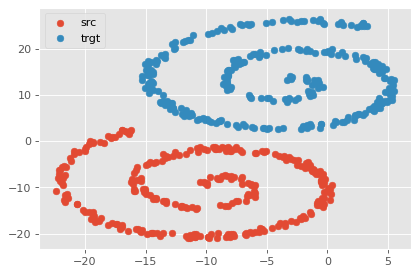

In [89]:
P2d = get_P(2,500)
P2d = torch.from_numpy(P2d).to(torch.float32)

Q = get_rot(1)
Xt = Xs @ Q + (10,10)
plt.scatter(Xs[:,0],Xs[:,1],label='src')
plt.scatter(Xt[:,0],Xt[:,1],label='trgt')
plt.legend()

We try to learn the rotation

RISGW affine map optimization, loss: 0.005774222780019045: 100%|██████████| 500/500 [00:17<00:00, 29.05it/s]


#### Reproduce paper 2d experiment

In [87]:
x_pred.mean(axis=0)

tensor([-14.3061,   3.3011], grad_fn=<MeanBackward1>)

In [86]:
sgw_gpu(xt+torch.Tensor([-10,0]),x_pred,device,P=P2d)

tensor(-0.0070, grad_fn=<MeanBackward0>)

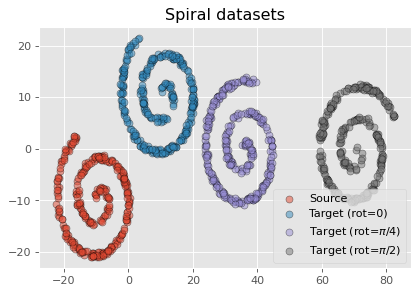

In [32]:
n_samples=300
theta=0#p.pi/2
scale=1

Xs,Xt=get_data(n_samples,theta,scale=scale,transla=10)

temp,Xt2=get_data(n_samples,np.pi/2,scale=scale)
temp,Xt22=get_data(n_samples,np.pi/4,scale=scale)
Xt2[:,0]+=70
Xt22[:,0]+=35
a=0.5
plt.figure(2)
plt.clf()
plt.scatter(Xs[:,0],Xs[:,1],marker='o',s=40,edgecolors='k',alpha=a,label='Source')
plt.scatter(Xt[:,0],Xt[:,1],marker='o',s=40,edgecolors='k',alpha=a,label="Target (rot=0)")
plt.scatter(Xt22[:,0],Xt22[:,1],marker='o',s=40,edgecolors='k',alpha=a,label="Target (rot=$\pi/4$)")
plt.scatter(Xt2[:,0],Xt2[:,1],marker='o',s=40,edgecolors='k',alpha=a,label="Target (rot=$\pi/2$)")
plt.title('Spiral datasets')
plt.legend()
plt.show()

In [5]:
nbrot=10
nbloop=5
angles=np.linspace(0,np.pi/2,nbrot)
scale=1
L=20

In [6]:
SGW=np.zeros((nbloop,nbrot))
RISGW=np.zeros((nbloop,nbrot))
rota={}
fname="./spirale_rot2_L{}_nbloop{}_nbrot{}.npz"
for i in range(nbloop):
    
    P=get_P(2,L)
    Xs,Xt0=get_data(n_samples,0,scale=scale)
    
    for j,theta in enumerate(tqdm(angles)):
        A=get_rot(theta)
        Xt=Xt0.dot(A)
        xs=torch.from_numpy(Xs).to(torch.float32)
        xt=torch.from_numpy(Xt).to(torch.float32)
        P2=torch.from_numpy(P).to(torch.float32)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                        
        SGW[i,j]=sgw_gpu(xs,xt,device=device,P=P2)
                
        RISGW[i,j]=risgw_gpu(xs,xt,device=device,P=P2,max_iter=600,verbose=False)
                        
        np.savez(fname.format(L,nbloop,nbrot),angles=angles,SGW=SGW,RISGW=RISGW)
    print('!!!!!!!!!!!!!!!!{0} Loop Done!!!!!!!!!!!!!!!!'.format(i))

In [7]:
res=np.load(fname.format(L,nbloop,nbrot))     
angles=res["angles"]
SGW=res["SGW"]
RISGW=res["RISGW"]

ipykernel_launcher:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


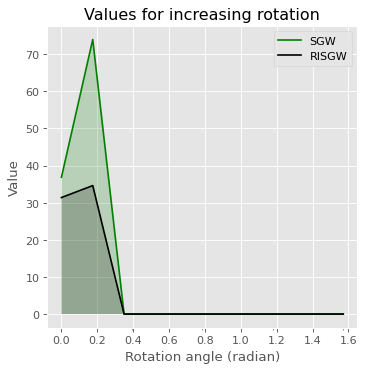

In [8]:
do_err=True
fig,ax = plt.subplots(1,figsize=(5,5))

plot_perf(angles,SGW,'g','SGW',do_err,ax=ax)    
plot_perf(angles,RISGW,'k','RISGW',do_err,ax=ax) 

ax.set_title("Values for increasing rotation")
ax.set_xlabel('Rotation angle (radian)')

ax.set_xticks((0,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2),('0','$\pi/8$','$\pi/4$','$3\pi/8$','$\pi/2$'))
ax.set_ylabel('Value')
ax.legend()

### Our own experiment on 3d data

### Computation of RISGW on shifted spiral

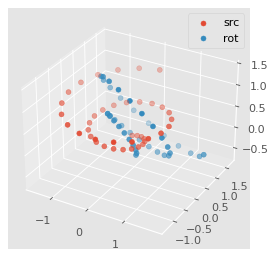

In [15]:
spiral, _ = get_src_scaled_spirals()

points = to_numpy_array(spiral)

noise = torch.rand(spiral.shape) * 0.0
noisy_spiral = spiral + noise
Q = get_rotation_matrix(theta=np.pi/2)
rot_noisy_spiral = noisy_spiral @ Q
trgt_points = to_numpy_array(rot_noisy_spiral)


_ = viz_point_cloud([(points,'src'),(trgt_points,'rot')])

We compute the distance between the source spiral and its noisy version as a baseline

In [16]:
P3d = np.random.randn(3,20) # 500 projections are used
P3d = torch.from_numpy(P3d).to(torch.float32)
risgw_gpu(spiral.squeeze(0),
          noisy_spiral.squeeze(0),
          device,
          P=P3d,
          max_iter=600)

RISGW affine map optimization, loss: -1.7166140509061734e-08: 100%|██████████| 600/600 [00:05<00:00, 108.60it/s]


tensor(-1.0872e-07, grad_fn=<MeanBackward0>)

And do the same with the noisy + rotated version: since risgw is assumed to be rotation invariant, the loss should be similar

In [18]:
P3d = np.random.randn(3,20) # 500 projections are used
P3d = torch.from_numpy(P3d).to(torch.float32)
risgw_gpu(spiral.squeeze(0),
          rot_noisy_spiral.squeeze(0),
          device,
          P=P3d,
          max_iter=1000)

RISGW affine map optimization, loss: 0.1126498207449913: 100%|██████████| 1000/1000 [00:10<00:00, 99.48it/s]


tensor(0.1126, grad_fn=<MeanBackward0>)

In [4]:
nbloop=1#5
angles=np.linspace(0,np.pi,nbrot)
n_proj=3#20

In [7]:
risgw_results = get_RISGW_3d_err_diff(angles,n_proj,nbloop,max_iter=100)

RISGW affine map optimization, loss: 1.6833332777023315: 100%|██████████| 10/10 [00:00<00:00, 191.51it/s]
RISGW affine map optimization, loss: 1.6833332777023315: 100%|██████████| 10/10 [00:00<00:00, 198.34it/s]
100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


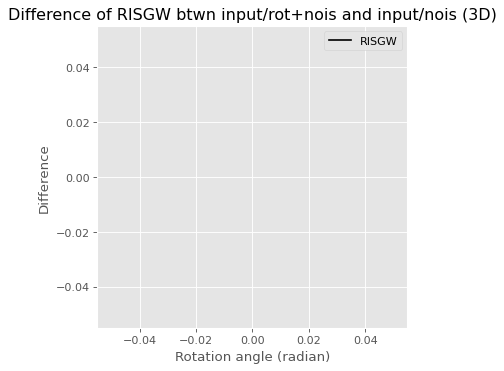

In [13]:
fig,ax = plt.subplots(1,figsize=(5,5))
plot_err_diff(angles,risgw_results,ax)